In [1]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_path = (r"D:\M.sc BDA\Projects\Lung Cancer Detection using CNN\Data\train")
val_path = (r"D:\M.sc BDA\Projects\Lung Cancer Detection using CNN\Data\valid")
test_path = (r"D:\M.sc BDA\Projects\Lung Cancer Detection using CNN\Data\test")

In [4]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


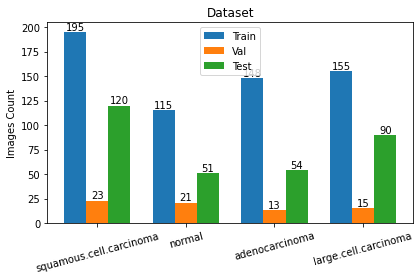

In [5]:
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.


In [7]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [8]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 72 images belonging to 4 classes.


In [9]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [10]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

Found 315 images belonging to 4 classes.


In [11]:
test_data.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

# RESNET 50 MODEL

In [21]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(350, 350,3),
                      include_top=False, weights="imagenet", 
                      pooling='max')

In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(4, activation='sigmoid'))

In [24]:
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])

In [25]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [26]:
# Fitting the Model
resnet = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8832
Epoch 1: val_accuracy improved from -inf to 0.88571, saving model to .\ct_resnet_best_model.hdf5
122/122 [==============================] - 261s 2s/step - loss: 0.4041 - accuracy: 0.8832 - val_loss: 0.5174 - val_accuracy: 0.8857
Epoch 2/32
122/122 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8898
Epoch 2: val_accuracy did not improve from 0.88571
122/122 [==============================] - 247s 2s/step - loss: 0.3384 - accuracy: 0.8898 - val_loss: 0.7106 - val_accuracy: 0.8000
Epoch 3/32
122/122 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.8997
Epoch 3: val_accuracy did not improve from 0.88571
122/122 [==============================] - 285s 2s/step - loss: 0.3039 - accuracy: 0.8997 - val_loss: 0.5172 - val_accuracy: 0.8429
Epoch 4/32
122/122 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8799
Epoch 4: val_accuracy

In [27]:
# Loading the Best Fit Model 
model = load_model("./ct_resnet_best_model.hdf5")

In [28]:
# Checking the Accuracy of the Model 
accuracy_resnet = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the model is = {accuracy_resnet*100} %")

The accuracy of the model is = 83.17460417747498 %


In [29]:
resnet.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

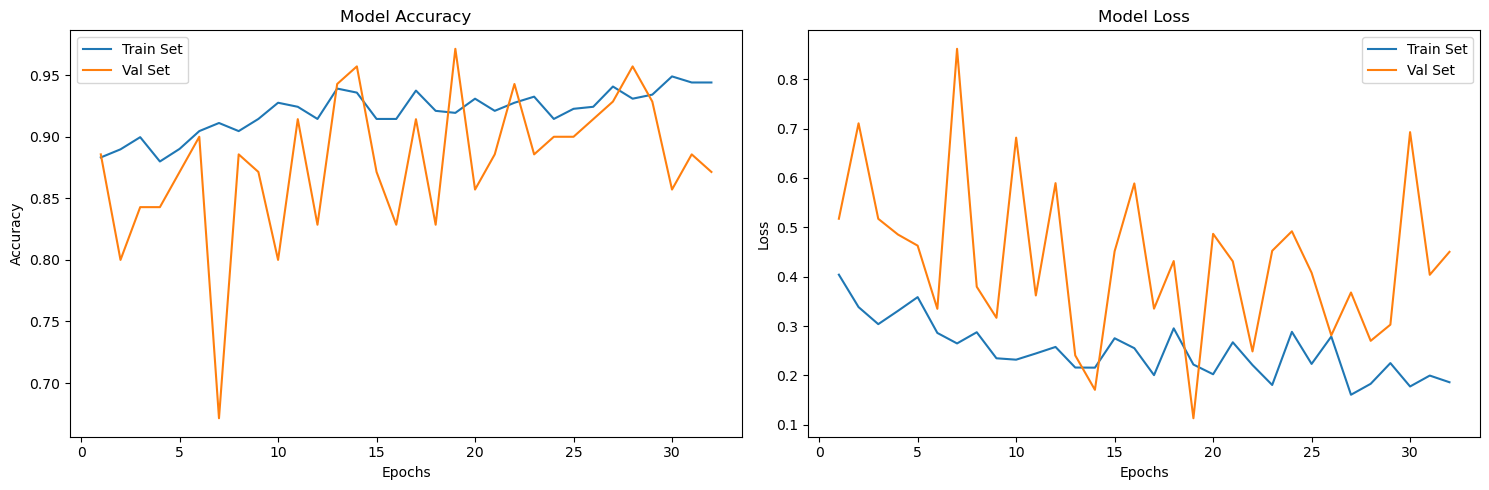

In [30]:
# Plot model performance
acc = resnet.history['accuracy']
val_acc = resnet.history['val_accuracy']
loss = resnet.history['loss']
val_loss = resnet.history['val_loss']
epochs_range = range(1, len(resnet.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


# Comparison

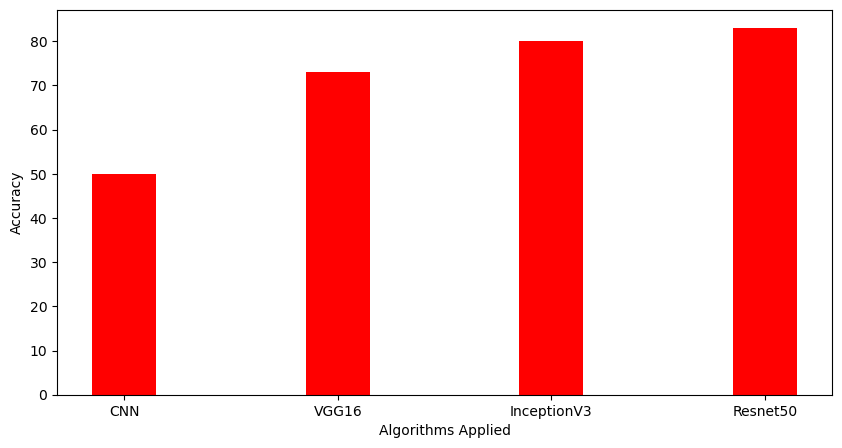

In [39]:
algorithms = ['CNN', 'VGG16', 'InceptionV3', 'Resnet50']
accuracy = [accuracy_cnn, accuracy_vgg, accuracy_incep, accuracy_resnet]
accuracy = np.floor([i * 100 for i in accuracy])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(algorithms, accuracy, color ='red', width = 0.3)
 
plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.show()

# 

# Prediction

In [23]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(350,350))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [26]:
path = r"C:\Users\jithi\Desktop\Data\test\adenocarcinoma\000128 (5).png"
chestScanPrediction(path,vgg_model)

1/1 [==============================] - 1s 643ms/step
Adenocarcinoma
